<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [39]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [40]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)


Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [72]:
import numpy as np

# Parse the attributes.txt file
attribute_map = {}
with open('data/attributes.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(' ', 1)  # Split at the first space
        if len(parts) == 2:
            attr_id, attr_desc = parts
            attribute_map[int(attr_id)] = attr_desc

# Load attributes.npy
attributes_array = np.load('data/attributes.npy')

# Example: Print the shape and a sample
print("Attributes Array Shape:", attributes_array.shape)
print("Sample Attributes:", attributes_array[:5])

Attributes Array Shape: (200, 312)
Sample Attributes: [[0.0106384  0.0106384  0.00709227 ... 0.00918617 0.02526198 0.02066889]
 [0.         0.01133243 0.00944369 ... 0.00266542 0.02132333 0.05863916]
 [0.         0.         0.00742474 ... 0.         0.00885258 0.01770516]
 [0.         0.         0.00386105 ... 0.00683957 0.03647772 0.04331729]
 [0.         0.03508838 0.         ... 0.0027513  0.01513216 0.15819981]]


In [79]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from PIL import Image

# Step 1: Read and preprocess the CSV
data = pd.read_csv('data/train_images.csv')

# Prepend 'data' to paths if not already present
data['image_path'] = data['image_path'].apply(lambda x: f"data{x}" if not x.startswith("data") else x)

# Verify the first few paths
print(data['image_path'].head())

# Check if files exist
for path in data['image_path'].head():
    print(f"{path} exists: {os.path.exists(path)}")

# Step 2: Define a PyTorch Dataset 
# import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from torch import nn

class CombinedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        #self.attributes = attributes  # This should be a list or array matching label indices
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert("RGB")  # Ensure 3 channels (RGB)
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        # Get the corresponding attribute for the label
        #attribute = self.attributes[label - 1]  # Assuming labels are 1-indexed
        
        return image, label

    def __len__(self):
        return len(self.image_paths)


# Define transformations
from torchvision import transforms
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Create dataset and dataloader
image_paths = data['image_path'].values
labels = data['label'].values - 1  # Ensure labels are zero-indexed (0 to 199)
print(labels)

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'image_paths' and 'labels' from your dataset
data_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Add attributes to the DataFrame
attribute_df = pd.DataFrame(attributes_array, columns=[f"attr_{i}" for i in range(attributes_array.shape[1])])
data_df = pd.concat([data_df, attribute_df], axis=1)

# Example: Check combined data
print(data_df.head())


# dataset = CombinedDataset(image_paths, attributes_array, labels, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

from sklearn.model_selection import train_test_split
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create training and validation datasets using the CombinedDataset class
train_dataset = CombinedDataset(X_train, y_train, transform=transform)
val_dataset = CombinedDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(len(image_paths))
print(len(attributes_array))
print(len(labels))


0    data/train_images/1.jpg
1    data/train_images/2.jpg
2    data/train_images/3.jpg
3    data/train_images/4.jpg
4    data/train_images/5.jpg
Name: image_path, dtype: object
data/train_images/1.jpg exists: True
data/train_images/2.jpg exists: True
data/train_images/3.jpg exists: True
data/train_images/4.jpg exists: True
data/train_images/5.jpg exists: True
[  0   0   0 ... 199 199 199]
                image_path  label    attr_0    attr_1    attr_2    attr_3  \
0  data/train_images/1.jpg      0  0.010638  0.010638  0.007092  0.003546   
1  data/train_images/2.jpg      0  0.000000  0.011332  0.009444  0.000000   
2  data/train_images/3.jpg      0  0.000000  0.000000  0.007425  0.000000   
3  data/train_images/4.jpg      0  0.000000  0.000000  0.003861  0.000000   
4  data/train_images/5.jpg      0  0.000000  0.035088  0.000000  0.000000   

     attr_4    attr_5    attr_6    attr_7  ...  attr_302  attr_303  attr_304  \
0  0.138299  0.065603  0.000000  0.005319  ...  0.000000  0.00543

In [86]:
import torch
import torch.nn as nn
import torchvision.models as models

class BirdClassificationModel(nn.Module):
    def __init__(self, num_image_features, num_classes):
        super(BirdClassificationModel, self).__init__()
        
        # CNN for image features (e.g., using ResNet18)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # Fully connected layers for attributes
        # self.fc_attributes = nn.Sequential(
        #     nn.Linear(num_attributes, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.5)
        # )
        
        # Final classification layer that combines image features and attribute features
        self.fc_combined = nn.Sequential(
            nn.Linear(num_image_features, 256),  # Assuming CNN output and attribute features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # Final output layer for classification
        )
    
    def forward(self, image):
        # Extract image features
        image_features = self.cnn(image)
        
        # Process attribute features
        # attribute_features = self.fc_attributes(attribute)
        
        # Combine image features and attribute features
        # combined_features = torch.cat((image_features), dim=1)
        
        # Classify combined features
        out = self.fc_combined(image_features)
        return out


In [87]:
# Initialize model
num_image_features = 512  # Output of ResNet18 after the final layer (512)
# num_attributes = attributes_array.shape[1]  # 312 if attributes have shape (N, 312)
num_classes = len(set(labels))  # Number of unique classes
model = BirdClassificationModel(num_image_features, num_classes).to(device)

# from sklearn.utils.class_weight import compute_class_weight

# labels = np.array(labels)
# print(len(np.unique(labels))) 

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:  # Assuming 'dataloader' is correctly set up
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients

        # Forward pass: pass both images and attributes to the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        # _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # epoch_loss = running_loss / len(dataloader)
    # epoch_accuracy = 100 * correct / total
    # print(f"Epoch {epoch + 1}/10, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    print(f"Epoch {epoch + 1}/{10}")
    print(f"Train Loss: {running_loss / len(train_loader):.4f}")
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10
Train Loss: 0.7833
Validation Loss: 0.6729
Validation Accuracy: 11.20%
Epoch 2/10
Train Loss: 0.4740
Validation Loss: 0.4535
Validation Accuracy: 14.12%
Epoch 3/10
Train Loss: 0.2252
Validation Loss: 0.3820
Validation Accuracy: 15.52%
Epoch 4/10
Train Loss: 0.1138
Validation Loss: 0.4187
Validation Accuracy: 15.78%
Epoch 5/10
Train Loss: 0.0793
Validation Loss: 0.3772
Validation Accuracy: 15.27%
Epoch 6/10
Train Loss: 0.0447
Validation Loss: 0.4211
Validation Accuracy: 13.74%
Epoch 7/10
Train Loss: 0.0618
Validation Loss: 0.4553
Validation Accuracy: 14.38%
Epoch 8/10
Train Loss: 0.0752
Validation Loss: 0.4337
Validation Accuracy: 14.63%
Epoch 9/10
Train Loss: 0.0564
Validation Loss: 0.4647
Validation Accuracy: 13.99%
Epoch 10/10
Train Loss: 0.0875
Validation Loss: 0.5135
Validation Accuracy: 12.34%


In [93]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 2: Load the test dataset using ImageFolder
test_dir = 'data/test_images'  # Path to your test image directory

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # No shuffle for evaluation

model.eval()  # Set the model to evaluation mode

predictions = []  # To store predictions
image_names = []  # To store image file names

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, _ in test_loader:
        # Extract image file names from the dataset
        batch_file_names = [
            os.path.splitext(os.path.basename(test_loader.dataset.samples[i][0]))[0] 
            for i in range(len(image_names), len(image_names) + len(images))
        ]
        image_names.extend(batch_file_names)

        images = images.to(device).float()  # Ensure images are float32
        
        # Model prediction
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions (on CPU)
        predictions.extend(predicted.cpu().numpy())

# Debugging lengths
print(f"Number of image names: {len(image_names)}")
print(f"Number of predictions: {len(predictions)}")

# Combine image names and predictions into a DataFrame
if len(image_names) != len(predictions):
    print(f"Mismatch detected: {len(image_names)} image names, {len(predictions)} predictions")
else:
    predicted_labels = pd.DataFrame({
        'id': image_names,
        'label': predictions
    })

    # Save the DataFrame to a CSV file
    predicted_labels.to_csv('predicted_labels.csv', index=False)
    print("Predictions have been saved to 'predicted_labels.csv'.")


Number of image names: 4000
Number of predictions: 4000
Predictions have been saved to 'predicted_labels.csv'.


In [6]:
import csv

# Data: structured as a list of dictionaries for each combination
data = [
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "SGD", "WD": 0.0001, "Momentum": 0.8, 
     "Epoch": 5, "Loss": 122.02611058950424, "Val Accuracy": 0.2684478371501272},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "SGD", "WD": 0.0001, "Momentum": 0.9, 
     "Epoch": 5, "Loss": 12.743182748556137, "Val Accuracy": 0.31297709923664124},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "SGD", "WD": 0.001, "Momentum": 0.8, 
     "Epoch": 5, "Loss": 8.090025622397661, "Val Accuracy": 0.3142493638676845},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "SGD", "WD": 0.001, "Momentum": 0.9, 
     "Epoch": 5, "Loss": 4.948834724724293, "Val Accuracy": 0.32951653944020354},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "Adam", "WD": 0.0001, "Momentum": 0.8, 
     "Epoch": 5, "Loss": 54.54459173977375, "Val Accuracy": 0.37659033078880405},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "Adam", "WD": 0.0001, "Momentum": 0.9, 
     "Epoch": 5, "Loss": 21.184185605496168, "Val Accuracy": 0.3422391857506361},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "Adam", "WD": 0.001, "Momentum": 0.8, 
     "Epoch": 5, "Loss": 21.73064725846052, "Val Accuracy": 0.31806615776081426},
    {"LR": 0.001, "Batch Size": 32, "Optimizer": "Adam", "WD": 0.001, "Momentum": 0.9, 
     "Epoch": 5, "Loss": 42.05024766176939, "Val Accuracy": 0.2506361323155216},
]

# Output file path
output_file = 'hyperparameter_results.csv'

# Write data to CSV
with open(output_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=data[0].keys())
    writer.writeheader()  # Write column headers
    writer.writerows(data)  # Write data rows

print(f"Data exported to {output_file}")


Data exported to hyperparameter_results.csv


/var/folders/w9/03c_s4jn509125_l99795s6c0000gn/T/ipykernel_10451/1318864327.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(wd_momentum_combinations))


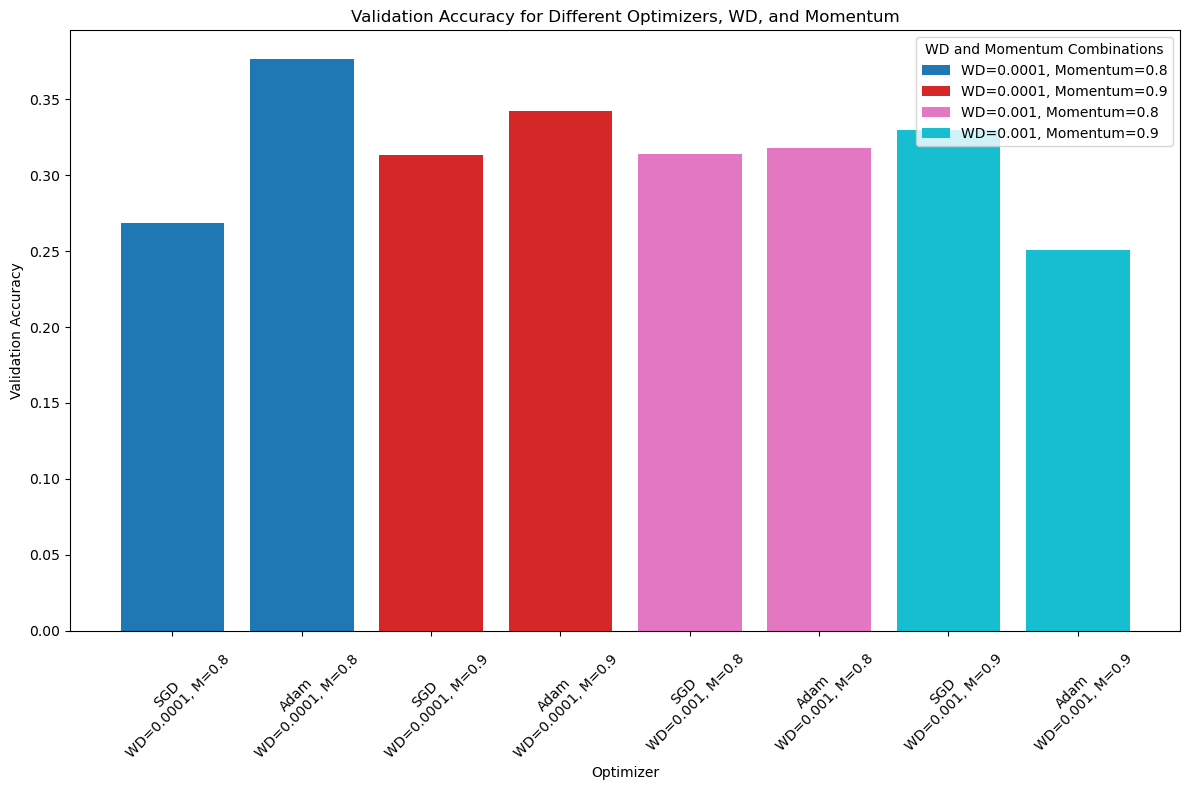

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv('hyperparameter_results.csv')

# Filter the data for Batch Size = 32
filtered_df = df[df['Batch Size'] == 32]

# Unique combinations of Weight Decay (WD) and Momentum
wd_momentum_combinations = filtered_df[['WD', 'Momentum']].drop_duplicates()

# Create a single figure
plt.figure(figsize=(12, 8))

# Define a color map
colors = plt.cm.get_cmap('tab10', len(wd_momentum_combinations))

# Iterate through each combination of WD and Momentum
for idx, (wd, momentum) in enumerate(wd_momentum_combinations.itertuples(index=False)):
    # Filter data for the specific combination
    subset = filtered_df[(filtered_df['WD'] == wd) & (filtered_df['Momentum'] == momentum)]
    
    # Plot for each Optimizer
    plt.bar(subset['Optimizer'] + f"\nWD={wd}, M={momentum}", subset['Val Accuracy'], color=colors(idx), label=f"WD={wd}, Momentum={momentum}")

# Customize the plot
plt.title("Validation Accuracy for Different Optimizers, WD, and Momentum")
plt.xlabel('Optimizer')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.legend(title="WD and Momentum Combinations")
plt.tight_layout()
plt.show()